<a href="https://colab.research.google.com/github/intimanjunath/Decision-trees-and-ensemble/blob/main/GradientBoosting_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRanker
from lightgbm import Dataset as LGBDataset, train as lgb_train
from catboost import CatBoostRanker, Pool
import matplotlib.pyplot as plt

In [4]:
# Generate synthetic dataset
np.random.seed(42)

# Parameters
num_groups = 10  # Number of groups (queries)
samples_per_group = 20  # Samples per group
num_features = 5  # Number of features

# Generate features, relevance scores, and group IDs
X = np.random.rand(num_groups * samples_per_group, num_features)  # Features
y = np.random.randint(1, 6, size=num_groups * samples_per_group)  # Relevance scores (1-5)
groups = [samples_per_group] * num_groups  # Groups of equal size

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_groups = groups[: int(len(groups) * 0.8)]  # Adjust groups for training
test_groups = groups[int(len(groups) * 0.8):]

In [5]:
# Train XGBoost Ranker
xgb_ranker = XGBRanker(
    objective="rank:pairwise",
    learning_rate=0.05,
    max_depth=4,
    n_estimators=120,
    random_state=42
)

# Train the model
xgb_ranker.fit(X_train, y_train, group=train_groups)

# Predict on the test set
xgb_predictions = xgb_ranker.predict(X_test)
print("XGBoost Ranking Predictions:", xgb_predictions)

XGBoost Ranking Predictions: [-0.27428016  0.22998913  0.1835314  -0.24435098  0.53015685  0.00770753
 -0.05557441  0.84099305  0.17155367  0.19785441  0.77950126 -0.1861643
 -0.520082   -0.1478546   0.01342384  0.5118698   0.27858335 -0.20068759
 -0.01681169  0.47606742 -0.34793985  0.68380934 -0.0625214  -0.25022918
 -0.00632701 -0.72988015  0.07951449  0.49635237  0.34054607  0.06941298
 -0.6324863  -0.14111179 -0.27109644  0.3354364   0.22473821  0.2152605
  0.5785179   0.1906095   0.33757675 -0.49030495]


In [7]:
# Prepare LightGBM datasets
lgb_train_data = LGBDataset(X_train, y_train, group=train_groups)
lgb_test_data = LGBDataset(X_test, y_test, group=test_groups, reference=lgb_train_data)

# Define parameters
lgb_params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.05,
    "max_depth": 4,
    "num_leaves": 31,
    "verbosity": -1
}

# Train LightGBM Ranker
lgb_ranker = lgb_train(
    params=lgb_params,
    train_set=lgb_train_data,
    valid_sets=[lgb_test_data],  # Validation set
    num_boost_round=120
)

# Predict on the test set
lgb_predictions = lgb_ranker.predict(X_test)
print("LightGBM Ranking Predictions:", lgb_predictions)

LightGBM Ranking Predictions: [-2.19100008  0.77930933  0.05775818 -0.80065427  1.44919393 -0.83224578
 -1.38861515  1.85241398 -0.60080133 -1.35756643  0.97881176 -0.8832544
 -2.28516249 -0.94623545 -0.16510928  1.44586428 -0.15112845 -1.33504638
 -1.79250813  1.44013091 -1.24696393  1.24545811 -0.3129942  -0.419095
 -1.08072683 -0.4451532   0.53004483  0.41990142  0.22525706 -0.56270627
 -1.20375246 -1.541047   -1.91444852  0.38687323 -0.17312673 -0.85940529
 -0.85229988  0.04489452 -0.53790861 -1.76840746]


In [8]:
# Prepare data pools for CatBoost
train_pool = Pool(X_train, y_train, group_id=np.repeat(range(len(train_groups)), train_groups))
test_pool = Pool(X_test, y_test, group_id=np.repeat(range(len(test_groups)), test_groups))

# Train CatBoost Ranker
cat_ranker = CatBoostRanker(
    iterations=120,
    learning_rate=0.05,
    depth=4,
    random_seed=42,
    verbose=10
)

# Train the model
cat_ranker.fit(train_pool)

# Predict on the test set
cat_predictions = cat_ranker.predict(test_pool)
print("CatBoost Ranking Predictions:", cat_predictions)

0:	total: 48ms	remaining: 5.71s
10:	total: 55.5ms	remaining: 550ms
20:	total: 70ms	remaining: 330ms
30:	total: 84.8ms	remaining: 244ms
40:	total: 93.7ms	remaining: 180ms
50:	total: 101ms	remaining: 136ms
60:	total: 108ms	remaining: 104ms
70:	total: 115ms	remaining: 79.4ms
80:	total: 122ms	remaining: 58.9ms
90:	total: 130ms	remaining: 41.4ms
100:	total: 137ms	remaining: 25.8ms
110:	total: 148ms	remaining: 12ms
119:	total: 156ms	remaining: 0us
CatBoost Ranking Predictions: [-0.79647324  0.6951821   0.65580896  0.54542346  1.11355068 -0.76910389
  0.10700284  2.07919903  0.38654017  0.24800921  1.93724536 -0.57034657
 -0.99721628 -0.60194256  0.52013495  1.1594852   0.61335182  0.28772513
 -0.26547614  0.55252693 -0.59182259  1.46416891 -0.44528172 -0.34476804
 -0.17792076 -1.01572696  0.84293117  0.88166283  0.3992885  -0.03165691
 -1.20135714 -0.95106198 -1.03008643  0.82070845  0.59000996  0.39598279
  0.57223089 -0.17871339  0.3989972  -0.9274998 ]


In [9]:
# Store predictions
ranking_predictions = {
    "XGBoost": xgb_predictions,
    "LightGBM": lgb_predictions,
    "CatBoost": cat_predictions
}

# Display predictions
for model, preds in ranking_predictions.items():
    print(f"{model} Predictions: {preds}")

XGBoost Predictions: [-0.27428016  0.22998913  0.1835314  -0.24435098  0.53015685  0.00770753
 -0.05557441  0.84099305  0.17155367  0.19785441  0.77950126 -0.1861643
 -0.520082   -0.1478546   0.01342384  0.5118698   0.27858335 -0.20068759
 -0.01681169  0.47606742 -0.34793985  0.68380934 -0.0625214  -0.25022918
 -0.00632701 -0.72988015  0.07951449  0.49635237  0.34054607  0.06941298
 -0.6324863  -0.14111179 -0.27109644  0.3354364   0.22473821  0.2152605
  0.5785179   0.1906095   0.33757675 -0.49030495]
LightGBM Predictions: [-2.19100008  0.77930933  0.05775818 -0.80065427  1.44919393 -0.83224578
 -1.38861515  1.85241398 -0.60080133 -1.35756643  0.97881176 -0.8832544
 -2.28516249 -0.94623545 -0.16510928  1.44586428 -0.15112845 -1.33504638
 -1.79250813  1.44013091 -1.24696393  1.24545811 -0.3129942  -0.419095
 -1.08072683 -0.4451532   0.53004483  0.41990142  0.22525706 -0.56270627
 -1.20375246 -1.541047   -1.91444852  0.38687323 -0.17312673 -0.85940529
 -0.85229988  0.04489452 -0.53790861

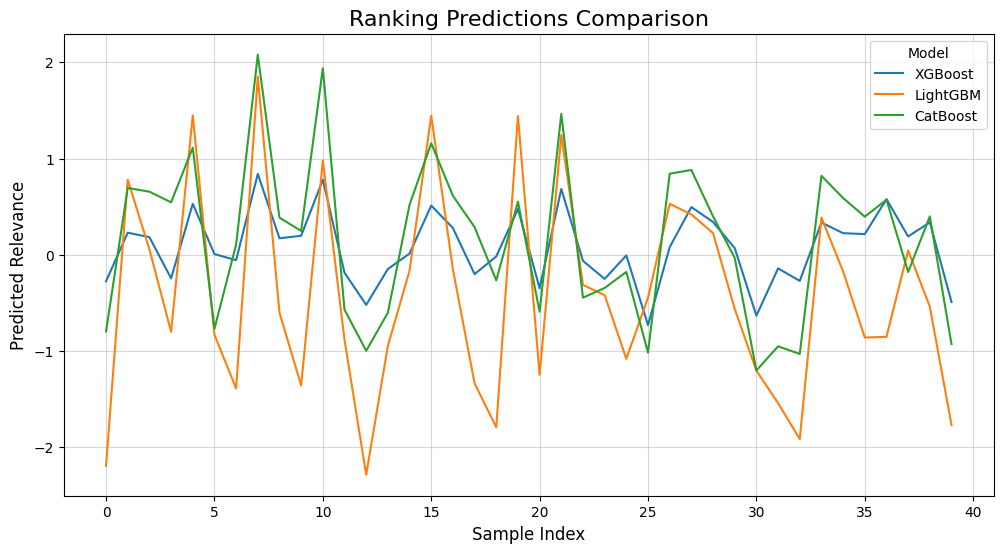

In [10]:
# Create a DataFrame for predictions
results_df = pd.DataFrame(ranking_predictions)

# Plot predictions
plt.figure(figsize=(12, 6))
for model in ranking_predictions.keys():
    plt.plot(results_df.index, results_df[model], label=model)

plt.title("Ranking Predictions Comparison", fontsize=16)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Predicted Relevance", fontsize=12)
plt.legend(title="Model")
plt.grid(alpha=0.5)
plt.show()